![HenryLogo](https://d31uz8lwfmyn8g.cloudfront.net/Assets/logo-henry-white-lg.png)

# **Proyecto integrador**

### 3. Modelamiento

Una vez preparados los datos, se procederá con el modelamiento. Recuerden que el objetivo es clasificar a un paciente como hospitalizado o no hospitalizado, teniendo en cuenta un data set que contiene información referente a antecedentes del paciente, morbilidad asociada al paciente y antecedentes relacionados con la toma de la biopsia y complicaciones infecciosas.




Carguen la base de datos preparada desde la fase 2.

In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.metrics import accuracy_score,f1_score, recall_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv("BBDD_hospitalizacion_codificado.csv")
df

,Edad,Diabetes,PSA,Biopsias_previas,Vol_prostatico,Antibiotico_profilaxis,Num_muestras,Enf_cronica_pulm_obstructiva,Biopsia,Fiebre,ITU,Hospitalizacion
0,53,0,4.0,0,1,0,12,0,0,1,0,1
1,56,0,7.7,0,1,0,12,0,0,1,0,1
2,57,0,29.0,1,1,0,24,0,0,1,0,1
3,56,0,7.0,0,1,0,12,0,0,1,0,1
4,55,0,29.0,1,1,0,24,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
426,55,0,5.0,0,0,0,12,0,2,0,0,0
427,70,1,18.0,0,1,0,12,0,0,0,0,0
428,75,0,75.0,0,1,0,12,0,5,0,0,0
429,67,0,6.0,0,1,0,12,0,1,0,0,0


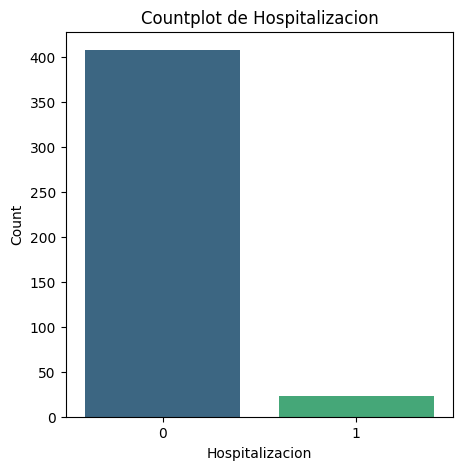

Hospitalizacion
0    408
1     23
Name: count, dtype: int64


In [3]:
plt.figure(figsize=(5,5))
sns.countplot(x="Hospitalizacion", data=df, palette="viridis")
plt.xlabel('Hospitalizacion')
plt.ylabel('Count')
plt.title('Countplot de Hospitalizacion')
plt.show()

print(df["Hospitalizacion"].value_counts())

La variable objetivo muestra un considerable desequilibrio entre las clases, con tan solo 23 registros pertenecientes a la clase positiva para la hospitalización.<br>
La idea es abordar el desequilibrio de clases durante el entrenamiento del modelo sin tocar el conjunto de prueba. La razón detrás de esto es asegurarse de que la evaluación del rendimiento del modelo en el conjunto de prueba sea una representación más realista de cómo se comportaría en datos no vistos.<br>
El proceso sería:
* Aplicar SMOTE solo al conjunto de entrenamiento, generando instancias sintéticas para equilibrar las clases.
* Entrenar el modelo con el conjunto de entrenamiento aumentado por SMOTE.
* Evaluar el rendimiento del modelo en el conjunto de prueba, que no ha sido modificado por SMOTE.

Separamos el dataset en X, y (variable objetivo)

In [4]:
X= df.drop("Hospitalizacion", axis=1)
y= df["Hospitalizacion"]

Separamos el dataset en el conjunto de entrenamiento y el conjunto test: X_train, X_test, y_train y y_test

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=50, stratify=y)
print("Cantidad de instancias en el conjunto de entrenamiento son:", len(X_train))
print("Cantidad de instancias en el conjunto de prueba:", len(X_test))
y_train_no = y_train.value_counts()[0]
y_train_si = y_train.value_counts()[1]
y_test_no = y_test.value_counts()[0]
y_test_si = y_test.value_counts()[1]
print("Cantidad de etiquetas en el conjunto de entrenamiento que son NO:", y_train_no)
print("Cantidad de etiquetas en el conjunto de entrenamiento que son SI:", y_train_si)
print("Cantidad de etiquetas en el conjunto de entrenamiento que son NO:", y_test_no)
print("Cantidad de etiquetas en el conjunto de entrenamiento que son SI:", y_test_si)

Cantidad de instancias en el conjunto de entrenamiento son: 301
Cantidad de instancias en el conjunto de prueba: 130
Cantidad de etiquetas en el conjunto de entrenamiento que son NO: 285
Cantidad de etiquetas en el conjunto de entrenamiento que son SI: 16
Cantidad de etiquetas en el conjunto de entrenamiento que son NO: 123
Cantidad de etiquetas en el conjunto de entrenamiento que son SI: 7


Realizamos un sobremuestreo para poder compensar el desbalanceo de clases que posee el conjunto de datos

In [6]:
smote = SMOTE(random_state=50)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("Cantidad de instancias en el conjunto de prueba:", len(X_train_smote))
y_train_smote_no = y_train_smote.value_counts()[0]
y_train_smote_si = y_train_smote.value_counts()[1]
print("Cantidad de etiquetas en el conjunto de entrenamiento que son NO:", y_train_smote_no)
print("Cantidad de etiquetas en el conjunto de entrenamiento que son SI:", y_train_smote_si)

Cantidad de instancias en el conjunto de prueba: 570
Cantidad de etiquetas en el conjunto de entrenamiento que son NO: 285
Cantidad de etiquetas en el conjunto de entrenamiento que son SI: 285


Instancien, entrenen y predigan sobre un árbol de decisión asignando una profundidad máxima arbitraria

In [7]:
prof_max_arbitraria = 8
model_tree = DecisionTreeClassifier(max_depth=prof_max_arbitraria)
model_tree.fit(X_train_smote,y_train_smote)
y_pred = model_tree.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.93      0.97       123
           1       0.47      1.00      0.64         7

    accuracy                           0.94       130
   macro avg       0.73      0.97      0.80       130
weighted avg       0.97      0.94      0.95       130



Para evaluar el rendimiento del modelo de clasificacion realizaremos una matriz de confusion y un mapa de calor para visualizar este rendimiento

[[115   0]
 [  8   7]]


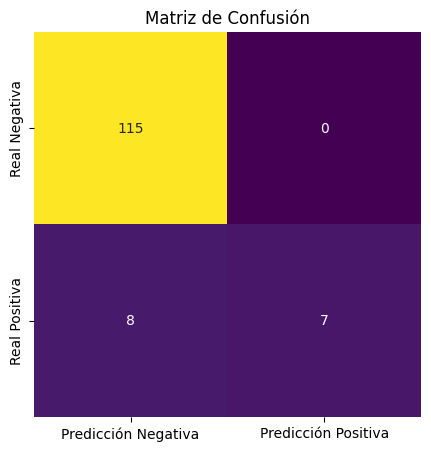

In [8]:
matriz_confusion = confusion_matrix(y_pred, y_test)
print(matriz_confusion)

plt.figure(figsize=(5,5))
sns.heatmap(matriz_confusion, annot=True,fmt="d", cmap="viridis", cbar=False,
            xticklabels=['Predicción Negativa', 'Predicción Positiva'],
            yticklabels=['Real Negativa', 'Real Positiva'])
plt.title('Matriz de Confusión')
plt.show()

Precision y Recall:

La precisión para la clase mayoritaria (etiqueta 0) es perfecta (1.00), indicando que todas las predicciones positivas para esta clase son correctas.
La precisión para la clase minoritaria (etiqueta 1) es más baja (0.41), lo que sugiere que hay falsos positivos en las predicciones para esta clase.
El recall es alto para ambas clases, especialmente para la clase minoritaria (1.00), lo que indica que el modelo es efectivo para capturar la mayoría de las instancias positivas reales.<br>
F1-Score:

El F1-Score, que equilibra precision y recall, es alto para la clase mayoritaria (0.96) pero más bajo para la clase minoritaria (0.58).
Esto sugiere que hay un compromiso entre la precisión y el recall en la clasificación de la clase minoritaria.<br>
Exactitud (Accuracy):

La exactitud general del modelo es del 92%, lo cual es un buen indicador general del rendimiento, pero debe interpretarse con precaución en conjuntos de datos desequilibrados.

### Visualizacion de la importancia de cada variable respecto a la variable objetivo

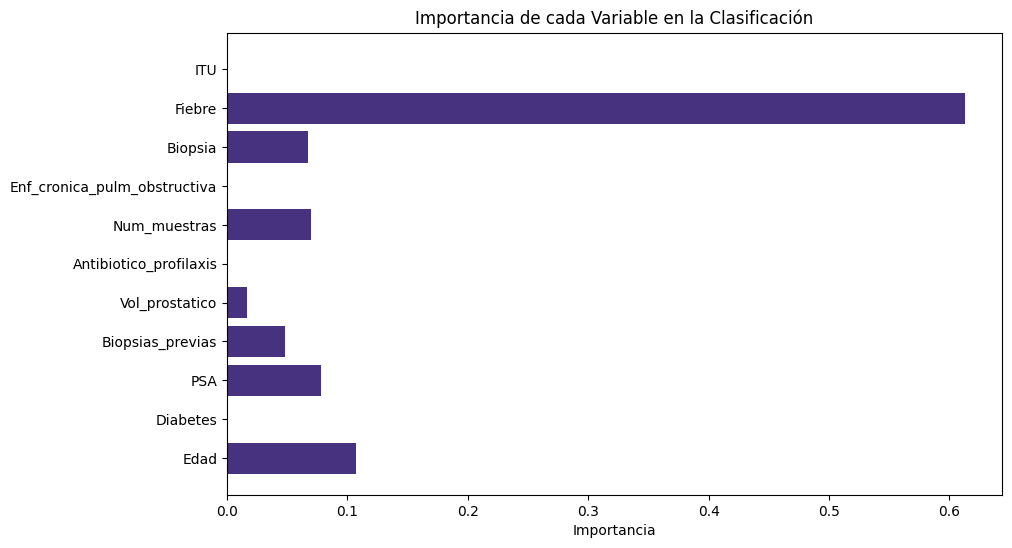

In [9]:
imp_variables = model_tree.feature_importances_
nombre_variables = list(X.columns)

plt.figure(figsize=(10, 6))
sns.set_palette('viridis')
plt.barh(nombre_variables, imp_variables)
plt.xlabel('Importancia')
plt.title('Importancia de cada Variable en la Clasificación')
plt.show()

Encuentre cuál sería un valor óptimo para el hiperparámetro **max_depth** para el árbol de decisión. Construya un modelo con este valor y compare las métricas de evaluación respecto al modelo creado con una profundidad arbitraria. 

In [10]:
modelo_arbol = DecisionTreeClassifier()
parametros_grid = {'max_depth': [3,4,5,6,7,8,9,10]}
grid_search = GridSearchCV(modelo_arbol, parametros_grid, cv=5, scoring="precision")
grid_search.fit(X_train_smote, y_train_smote)
mejor_max_depth = grid_search.best_params_['max_depth']
modelo_mejorado = DecisionTreeClassifier(max_depth=mejor_max_depth)
modelo_mejorado.fit(X_train_smote, y_train_smote)
y_pred_mejorado = modelo_mejorado.predict(X_test)
print(classification_report(y_test, y_pred_mejorado))
print(f"Mejor valor para max_depth: {mejor_max_depth}")

              precision    recall  f1-score   support

           0       1.00      0.89      0.94       123
           1       0.35      1.00      0.52         7

    accuracy                           0.90       130
   macro avg       0.68      0.95      0.73       130
weighted avg       0.96      0.90      0.92       130

Mejor valor para max_depth: 9


* Modelo Sin Mejorar:

Tiene una alta precisión para los casos en los que el paciente no fue hospitalizado (clase 0), lo que significa que cuando predice que un paciente no será hospitalizado, es probable que sea correcto.
Logra una alta sensibilidad (recall) para los casos en los que el paciente fue hospitalizado (clase 1), lo que indica que identifica correctamente a la mayoría de los pacientes hospitalizados.<br>

* Modelo Mejorado:

Aunque la precisión para los casos en los que el paciente no fue hospitalizado (clase 0) sigue siendo alta, la precisión para los casos en los que el paciente fue hospitalizado (clase 1) disminuye. Sin embargo, esto se compensa con un aumento en el recall para la clase 1.
Tener un recall del 100% para la clase 1 significa que el modelo mejorado identifica correctamente a todos los pacientes que fueron hospitalizados.

Instancien, entrenen y predigan sobre un modelo de k-vecinos asignando una cantidad de vecinos k-aribitraria. 

Encuentre el valor óptimo para k

Halle las mismas tres métricas de evaluación para este modelo de clasificación y compare los valores para el performance, respecto al árbol de decisión cuyo hiperparámetro **max_depth** se optimizó. ¿Qué puede concluir? 

De acuerdo con lo aprendido en el módulo, ¿Cómo cree que se puede mejorar el performance de este modelo? 

R/